In [12]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import numpy as np 
import pandas as pd
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
import torch
from featurelearning.models.signet import SigNet
from preprocessing.normalize import crop_center
import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

Using device: cuda


In [3]:
npz_dir = 'C:\\Users\\Mert\\Documents\\GitHub\\sigver_v2\\npz\\gpds4k.npz'

In [4]:
with np.load(npz_dir, allow_pickle=True) as data:
        x, y, yforg, user_mapping, filenames = data['x'], data['y'], data['yforg'], data['user_mapping'], data['filenames']

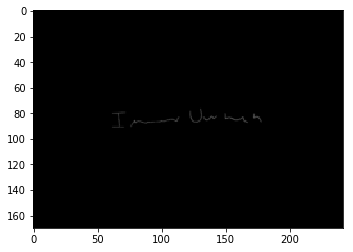

In [5]:
# Plot a sample
plt.imshow(x[2,0,:,:],cmap='gray',vmin=0,vmax=255)
plt.show()

In [6]:
state_dict, classification_layer, forg_layer = torch.load('saved_models/gpds4k-f-0999L2_net.pth')
base_model = SigNet().to(device).eval()
base_model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

* Crop the middle 150x220

In [7]:
xc = np.zeros((x.shape[0],1,150,220), dtype=np.uint8)
for idx in tqdm.tqdm(np.arange(x.shape[0]),ascii=True):
    xc[idx,0,:,:] = crop_center(x[idx,0,:,:], (150,220))

100%|#######################################################################| 216000/216000 [00:17<00:00, 12021.08it/s]


In [8]:
del x 

In [9]:
visual_f=np.zeros((xc.shape[0],2048))

In [10]:
visual_f.shape

(216000, 2048)

In [11]:
with torch.no_grad():
    for idx,gpu_slice in enumerate(np.split(xc,250)):
        visual_f[idx*len(gpu_slice):(idx+1)*len(gpu_slice),:] = base_model(torch.tensor(gpu_slice).float().div(255).to(device)).cpu()

In [12]:
visual_f = pd.DataFrame(visual_f)

In [13]:
visual_f.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,0.296794,0.054041,1.482445,0.046547,0.000000,0.0,0.034372,0.171243,0.0,...,0.000000,0.000000,0.000000,0.000000,0.452807,0.111740,0.0,0.0,0.131535,0.000000
1,0.751521,0.220826,0.066615,0.302663,0.000000,0.142470,0.0,0.369951,0.000000,0.0,...,0.000000,0.000000,0.002101,0.174642,0.421599,0.076334,0.0,0.0,0.186776,0.000000
2,0.000000,0.225271,0.002716,0.000000,0.052612,0.000000,0.0,0.371115,0.000000,0.0,...,0.171636,0.000000,0.026828,0.191547,0.430543,0.130247,0.0,0.0,0.278173,0.384287
3,0.056965,0.011040,0.051867,0.302583,0.000000,0.153977,0.0,0.440728,0.000000,0.0,...,0.000000,0.000000,0.000000,0.464118,0.329847,0.012519,0.0,0.0,0.278593,0.000000
4,1.198866,0.255626,0.099902,1.199899,0.027524,0.342910,0.0,0.312641,0.000000,0.0,...,0.000000,0.292207,0.155912,0.184085,0.242108,0.012301,0.0,0.0,0.441605,0.000000


In [14]:
if npz_dir.endswith('gpds4k.npz'):
    sig_ids = np.array([int(fname.lower().split('-')[-1].split('.')[0]) for fname in np.squeeze(filenames)])
    user_ids = np.array([int(fname.lower().split('-')[1]) for fname in np.squeeze(filenames)])
elif npz_dir.endswith('mcyt.npz'):
    user_ids = np.array([int(fname.lower().split('_')[-1].split('v')[0].split('f')[0]) for fname in np.squeeze(filenames)])
    sig_ids = np.array([int(fname.lower().split('_')[-1].split('v')[-1].split('f')[-1].split('.')[0])+1 for fname in np.squeeze(filenames)])

In [15]:
filenames_ex = np.expand_dims(filenames,axis=1)
yforg_ex = np.expand_dims(yforg,axis=1)
sig_ids_ex = np.expand_dims(sig_ids,axis=1)
user_ids_ex = np.expand_dims(user_ids,axis=1)

In [16]:
data_f=pd.DataFrame(np.concatenate((filenames_ex, user_ids_ex, sig_ids_ex, yforg_ex),axis=1), columns=['path', 'user_id', 'sig_id', 'fakeness'])

In [18]:
save_path = 'C:\\Users\\Mert\\Documents\\GitHub\\sigver_bmg\\data\\GPDSSyntheticSignatures4k\\bmgnet-f0999_features'
data_f.to_csv(os.path.join(save_path,'data_features.csv'),index=False)
visual_f.to_csv(os.path.join(save_path,'visual_features.csv'),index=False)